In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

In [2]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)
        if c == 1:
            plt.imshow(img_resized)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        c += 1

    return np.array(X), np.array(y)

In [3]:
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Zamroź warstwy

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Wyjście
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

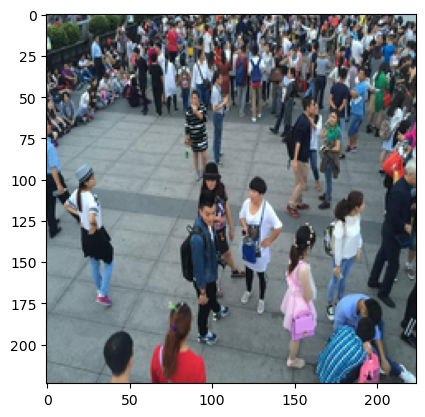

In [4]:
X_1, y_1 = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

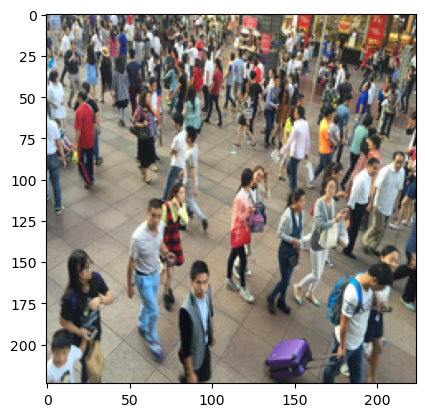

In [5]:
X_2, y_2 = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

In [6]:
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)
history = model.fit(dataset, batch_size=32,
    epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 609ms/step - loss: 24659.3223 - mae: 125.6189 - val_loss: 19950.7734 - val_mae: 114.8878
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 537ms/step - loss: 21686.0625 - mae: 112.7789 - val_loss: 9937.1299 - val_mae: 69.5895
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - loss: 10827.2314 - mae: 76.5678 - val_loss: 6397.8242 - val_mae: 61.5351
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 559ms/step - loss: 8672.6992 - mae: 69.5790 - val_loss: 6180.6787 - val_mae: 59.5765
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 553ms/step - loss: 8378.0205 - mae: 69.4311 - val_loss: 5960.4795 - val_mae: 57.5932
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - loss: 8027.4863 - mae: 67.2966 - val_loss: 5698.0679 - val_mae: 56.1407
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 548ms/step - loss: 7578.2808 - mae: 65.1287 - val_loss: 5375.7529 - val_mae: 53.8330
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 564ms/step - loss: 7020.0264 - mae: 62.3563 - val_loss: 4970.5

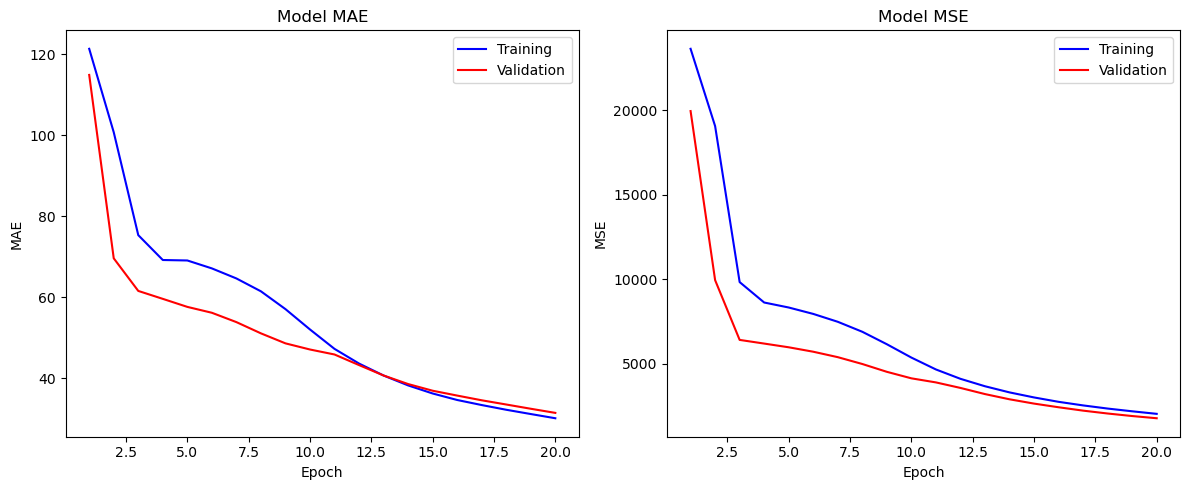

In [9]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
y_pred = np.round(model.predict(X_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step


In [11]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[246. 156.]
 [181. 267.]
 [ 93.  86.]
 [116. 143.]
 [ 41.  54.]
 [ 35.  36.]
 [ 57.  48.]
 [ 73.  42.]
 [112. 118.]
 [260. 281.]
 [ 87. 106.]
 [ 23.  35.]
 [125. 138.]
 [247. 251.]
 [ 84. 123.]
 [209. 146.]
 [111.  74.]
 [197. 129.]
 [ 61.  85.]
 [244. 176.]
 [ 70.  64.]
 [ 47.  28.]
 [162. 132.]
 [ 75.  93.]
 [247. 298.]
 [177. 217.]
 [110.  61.]
 [182. 111.]
 [ 63.  87.]
 [ 59.  53.]
 [ 59.  73.]
 [139.  94.]
 [242. 265.]
 [210. 166.]
 [ 41.  28.]
 [119.  68.]
 [178. 229.]
 [191. 165.]
 [ 76.  35.]
 [116.  66.]
 [ 62.  47.]
 [186. 132.]
 [ 46.  60.]
 [169. 150.]
 [ 41.  38.]
 [ 65.  79.]
 [140. 123.]
 [ 56.  57.]
 [ 62.  57.]
 [112.  94.]
 [ 48.  35.]
 [ 48.  21.]
 [ 79. 114.]
 [223. 203.]
 [ 39.  28.]
 [ 61.  51.]
 [206. 159.]
 [ 50.  36.]
 [156. 133.]
 [207. 155.]
 [ 82.  97.]
 [325. 277.]
 [ 63.  54.]
 [ 31.  25.]
 [ 55.  29.]
 [ 53.  80.]
 [ 82. 104.]
 [165. 107.]
 [296. 344.]
 [204. 205.]
 [ 92.  83.]
 [192. 132.]
 [104.  84.]
 [283. 164.]
 [ 84. 104.]
 [185. 142.]
 [297. 235.]

In [12]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7398850917816162